https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

# Recap

We started by learning about permutation importance and partial dependence plots for an overview of what the model has learned.

We then learned about SHAP values to break down the components of individual predictions.

Now we'll expand on SHAP values, seeing how aggregating many SHAP values can give more detailed alternatives to permutation importance and partial dependence plots.

# SHAP Values Review

Shap values show how much a given feature changed our prediction (compared to if we made that prediction at some baseline value of that feature).

For example, consider an ultra-simple model:

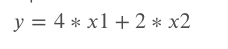


If  𝑥1  takes the value 2, instead of a baseline value of 0, then our SHAP value for  𝑥1  would be 8 (from 4 times 2).

These are harder to calculate with the sophisticated models we use in practice. But through some algorithmic cleverness, Shap values allow us to decompose any prediction into the sum of effects of each feature value, yielding a graph like this:

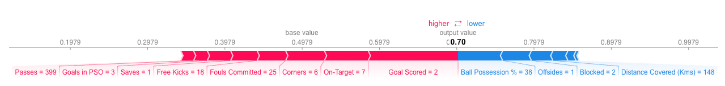

Link to larger view: https://i.imgur.com/JVD2U7k.png

In addition to this nice breakdown for each prediction, the [Shap library](https://github.com/slundberg/shap) offers great visualizations of groups of Shap values. We will focus on two of these visualizations. These visualizations have conceptual similarities to permutation importance and partial dependence plots. So multiple threads from the previous exercises will come together here.

# Summary Plots

[Permutation importance](https://www.kaggle.com/dansbecker/permutation-importance) is great because it created simple numeric measures to see which features mattered to a model. This helped us make comparisons between features easily, and you can present the resulting graphs to non-technical audiences.

But it doesn't tell you how each features matter. If a feature has medium permutation importance, that could mean it has

- a large effect for a few predictions, but no effect in general, or
- a medium effect for all predictions.

SHAP summary plots give us a birds-eye view of feature importance and what is driving it. We'll walk through an example plot for the soccer data:



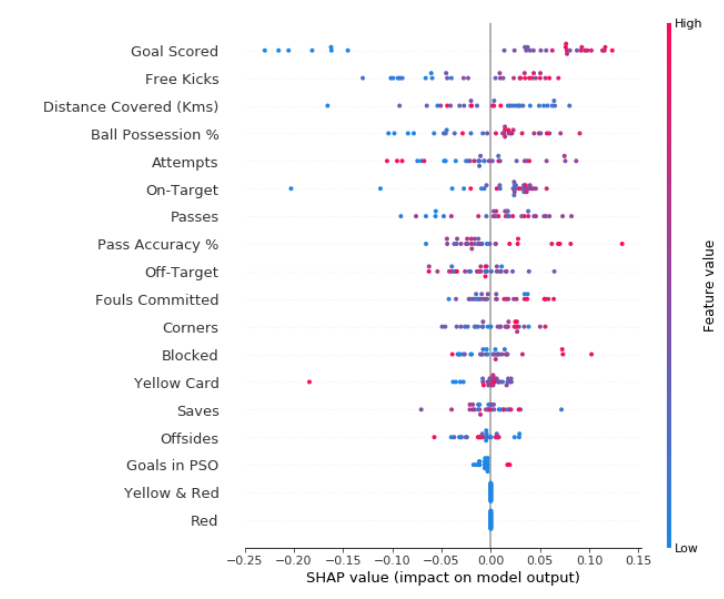

This plot is made of many dots. Each dot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

For example, the point in the upper left was for a team that scored few goals, reducing the prediction by 0.25.

Some things you should be able to easily pick out:

- The model ignored the Red and Yellow & Red features.
- Usually Yellow Card doesn't affect the prediction, but there is an extreme case where a high value caused a much lower prediction.
- High values of Goal scored caused higher predictions, and low values caused low predictions

If you look for long enough, there's a lot of information in this graph. You'll face some questions to test how you read them in the exercise.

# Summary Plots in code:

You have already seen the code to load the soccer/football data:



In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

data.head()

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


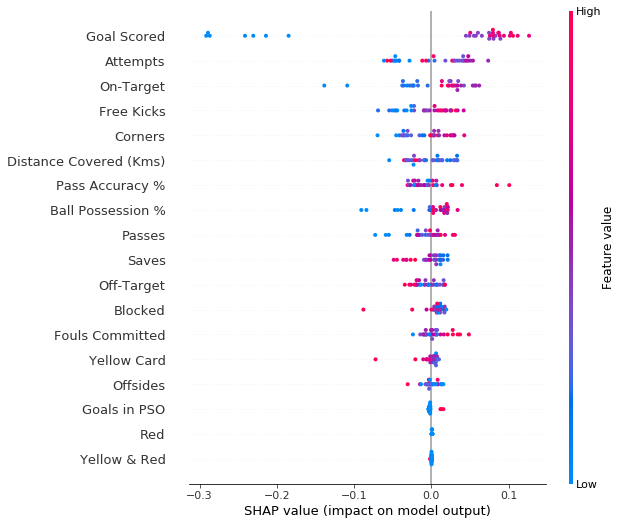

In [3]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

The code isn't too complex. But there are a few caveats.

- When plotting, we call shap_values[1]. For classification problems, there is a separate array of SHAP values for each possible outcome. In this case, we index in to get the SHAP values for the prediction of "True".
- Calculating SHAP values can be slow. It isn't a problem here, because this dataset is small. But you'll want to be careful when running these to plot with reasonably sized datasets. The exception is when using an xgboost model, which SHAP has some optimizations for and which is thus much faster.

This provides a great overview of the model, but we might want to delve into a single feature. That's where SHAP dependence contribution plots come into play.

# SHAP Dependence Contribution Plots

We've previously used Partial Dependence Plots to show how a single feature impacts predictions. These are insightful and relevant for many real-world use cases. Plus, with a little effort, they can be explained to a non-technical audience.

But there's a lot they don't show. For instance, what is the distribution of effects? Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.



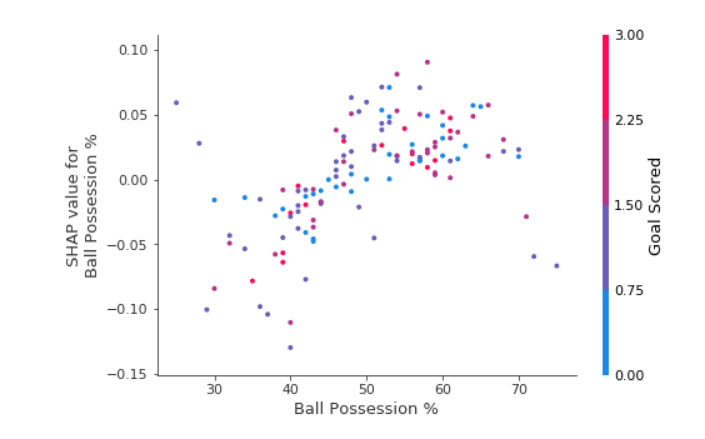

Start by focusing on the shape, and we'll come back to color in a minute. Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact this slopes upward says that the more you possess the ball, the higher the model's prediction is for winning the Man of the Match award.

The spread suggests that other features must interact with Ball Possession %. For example, here we have highlighted two points with similar ball possession values. That value caused one prediction to increase, and it caused the other prediction to decrease.

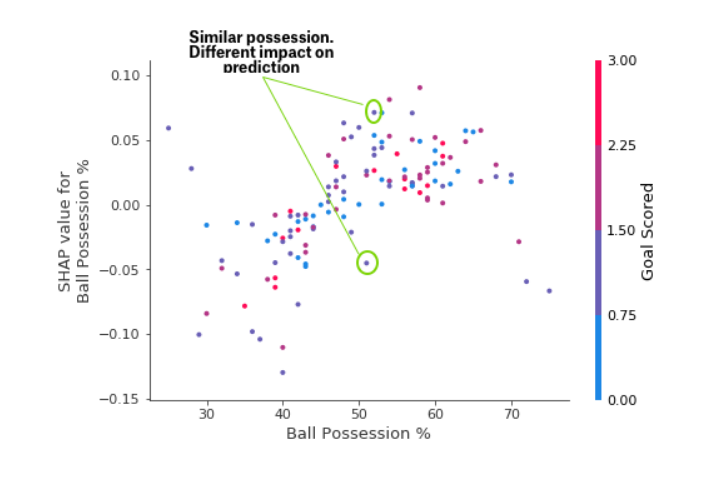

For comparison, a simple linear regression would produce plots that are perfect lines, without this spread.

This suggests we delve into the interactions, and the plots include color coding to help do that. While the primary trend is upward, you can visually inspect whether that varies by dot color.

Consider the following very narrow example for concreteness.


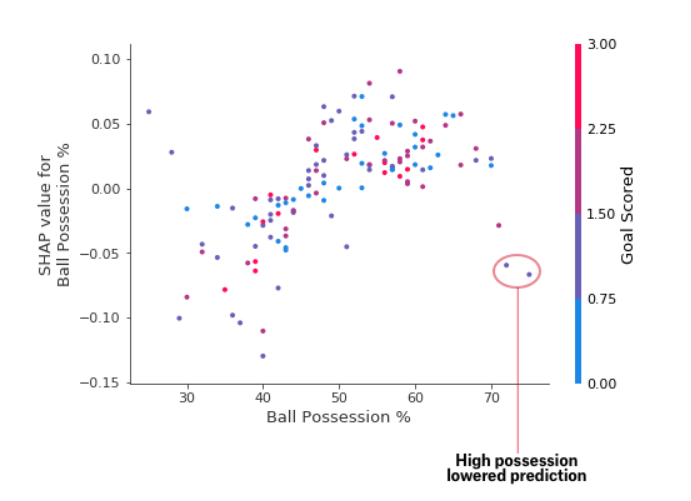

These two points stand out spatially as being far away from the upward trend. They are both colored purple, indicating the team scored one goal. You can interpret this to say **In general, having the ball increases a team's chance of having their player win the award. But if they only score one goal, that trend reverses and the award judges may penalize them for having the ball so much if they score that little.**

Outside of those few outliers, the interaction indicated by color isn't very dramatic here. But sometimes it will jump out at you.


# Dependence Contribution Plots in Code

We get the dependence contribution plot with the following code. The only line that's different from the summary_plot is the last line.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


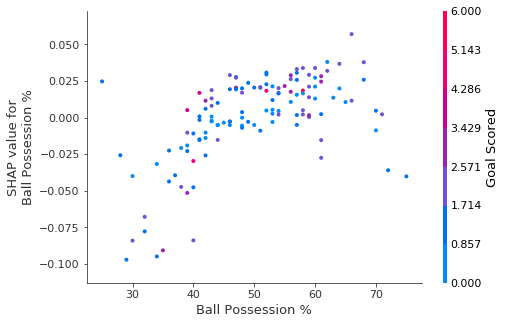

In [6]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

If you don't supply an argument for interaction_index, Shapley uses some logic to pick one that may be interesting.

This didn't require writing a lot of code. But the trick with these techniques is in thinking critically about the results rather than writing code itself.

# Exercise

- https://www.kaggle.com/hamelhusain/exercise-advanced-uses-of-shap-values/edit

- This exercise includes imporant examples

- The SHAP library is preferrable to the mess that is Partial Dependence

In [7]:
! open .